## Job Generation

In [57]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import csv

## Constant Parameters

In [58]:
# number of jobs
n = 10000
number_of_queues = 4
lmbda = 0.1
mu = 0.2
time_slice = 4.5
filePath = "jobs.csv"
interleave_graph_times = []

In [59]:

jobsArray = []

class Job:
    def __init__(self, arrival_time, service_time, priority):
        self.arrival_time = arrival_time
        self.service_time = service_time
        self.priority = priority
        self.sojourn_time = 0
        self.latency_due_to_preemption = 0
        self.waiting_time = 0
        self.pre_waiting_time = 0
        self.service_start_time = None
        self.service_end_time = None
        self.last_service_time = None
        self.isJobDone = False
        self.service_left = service_time
        self.num_preemptions = 0

def load_jobs_from_csv(file_path):
    jobs = []
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        next(csv_reader)  # Skip header if present
        for row in csv_reader:
            arrival_time, service_time, priority = map(float, row)
            job = Job(arrival_time, service_time, priority)
            jobs.append(job)
    return jobs        

def generate_exponential_xi(n, lmbda):
    y = np.random.uniform(0, 1, n)
    x = [-np.log(1 - y[i]) / lmbda for i in range(len(y))]
    return x

def generate_si_sigma_xi(n):
    n_sorted = sorted(n)
    si_sigma_xi = []
    for i in range(len(n_sorted)):
        si_sigma_xi.append(sum(n_sorted[:i+1]))
    return si_sigma_xi

def generate_sizes(si_sigma_xi, mu):
    sizes = generate_exponential_xi(len(si_sigma_xi), mu)
    jobs = []
    for i in range(len(si_sigma_xi)):
        jobs.append(Job(si_sigma_xi[i], sizes[i], None))
    return jobs

def assign_priority(jobsArray, number_of_queues, average_service_time):
    bin_size = 2 * average_service_time / number_of_queues
    for job in jobsArray:
        priority = int(job.service_time / bin_size)
        if priority >= number_of_queues:
            priority = number_of_queues - 1
        job.priority = priority
    return jobsArray

def areJobsLeft(jobsArray):
    for job in jobsArray:
        if job.isJobDone == False:   
            return True
    return False

def getHighestPriorityJob(jobsArray,global_clock):
    index = -1
    priority = 100000
    for i, job in enumerate(jobsArray):
        if job.priority <= priority and global_clock >= job.arrival_time and job.isJobDone == False:
            priority = job.priority
            index = i 
            
    return index

def getNextJobArrival(jobsArray):
    for i, job in enumerate(jobsArray):
        if job.isJobDone == False:
            return i
    return None  # Return None if no more jobs are left

def simulate_queue(jobsArray, numJobs, time_slice):
    global_clock = 0
    numJobsdone = 0
    time_slice = time_slice
    last_job_index = -1
    while numJobsdone != numJobs:
        highest_priority_job_index = getHighestPriorityJob(jobsArray, global_clock)

        if highest_priority_job_index == -1:
            index = getNextJobArrival(jobsArray)
            if index is None:
                break  # No more jobs left, exit the loop
            global_clock = jobsArray[index].arrival_time
            highest_priority_job_index = index

        currJob = jobsArray[highest_priority_job_index]
        interleave_graph_times.append([global_clock, currJob.priority])
        if currJob.service_start_time is None:
            jobsArray[highest_priority_job_index].service_start_time = global_clock
            jobsArray[highest_priority_job_index].pre_waiting_time = global_clock - currJob.arrival_time
        else:
            jobsArray[highest_priority_job_index].latency_due_to_preemption += global_clock - jobsArray[highest_priority_job_index].last_service_time
            if last_job_index != highest_priority_job_index:
                jobsArray[highest_priority_job_index].num_preemptions += 1

        if currJob.service_left > time_slice:
            global_clock += time_slice
            jobsArray[highest_priority_job_index].service_left -= time_slice
        else:
            global_clock += currJob.service_left
            jobsArray[highest_priority_job_index].isJobDone = True
            jobsArray[highest_priority_job_index].service_left = 0
            jobsArray[highest_priority_job_index].service_end_time = global_clock
            jobsArray[highest_priority_job_index].waiting_time = jobsArray[highest_priority_job_index].pre_waiting_time + jobsArray[highest_priority_job_index].latency_due_to_preemption
            jobsArray[highest_priority_job_index].sojourn_time = jobsArray[highest_priority_job_index].waiting_time + jobsArray[highest_priority_job_index].service_time
            numJobsdone += 1

        last_job_index = highest_priority_job_index
        jobsArray[highest_priority_job_index].last_service_time = global_clock


## Queuing parameters

In [60]:

xi = generate_exponential_xi(n, lmbda)
si_sigma_xi = generate_si_sigma_xi(xi)
jobsArray = generate_sizes(si_sigma_xi, mu)
jobsArray = assign_priority(jobsArray, number_of_queues, 1/mu)    
# Count number of jobs in each queue
count = [0] * number_of_queues
for job in jobsArray:
    count[job.priority] += 1
print("Counts per priority:", count)

jobsArray = load_jobs_from_csv(filePath)

# Simulate the queue with the given arrival times and sizes using sjf
simulate_queue(jobsArray,n,time_slice)


Counts per priority: [3957, 2322, 1445, 2276]


In [61]:

print("Jobs:")
for job in jobsArray:
    print("Arrival Time:", job.arrival_time, "Service Time:", job.service_time, "Priority:", job.priority, "Waiting Time:", job.pre_waiting_time)


Jobs:
Arrival Time: 28.04237706189016 Service Time: 11.067683306426295 Priority: 3.0 Waiting Time: 0.0
Arrival Time: 46.11759596312337 Service Time: 1.1164683170540006 Priority: 0.0 Waiting Time: 0.0
Arrival Time: 62.41188469401335 Service Time: 0.7221013124594701 Priority: 0.0 Waiting Time: 0.0
Arrival Time: 63.60981575825973 Service Time: 3.710305933134673 Priority: 1.0 Waiting Time: 0.0
Arrival Time: 87.73571682402662 Service Time: 5.367841531301051 Priority: 2.0 Waiting Time: 0.0
Arrival Time: 89.42168407421266 Service Time: 2.1736512396714036 Priority: 0.0 Waiting Time: 3.17612228838793
Arrival Time: 92.03537893710512 Service Time: 0.3620895385739716 Priority: 0.0 Waiting Time: 0.20033788692150267
Arrival Time: 122.76151712145801 Service Time: 0.28065720238269465 Priority: 0.0 Waiting Time: 0.0
Arrival Time: 130.50474666795907 Service Time: 4.414836029427419 Priority: 1.0 Waiting Time: 0.0
Arrival Time: 132.23711908167544 Service Time: 0.3671559285267491 Priority: 0.0 Waiting Time

## Average Service Time for simulation

In [62]:

def getAverageServiceTime(jobsArray):
    totserviceTime = 0
    for job in jobsArray:
        totserviceTime += job.service_time
    avg_time = totserviceTime/len(jobsArray)
    return avg_time    

def getAverageWaitingTime(jobsArray):
    totWaitingTime = 0
    for job in jobsArray:
        totWaitingTime += job.pre_waiting_time+job.latency_due_to_preemption
    avg_time = totWaitingTime/len(jobsArray)
    return avg_time  

def getAverageSojournTime(jobsArray):
    totSojournTime = 0
    for job in jobsArray:
        totSojournTime += job.sojourn_time
    avg_time = totSojournTime/len(jobsArray)
    return avg_time 

print(getAverageServiceTime(jobsArray))
print(getAverageWaitingTime(jobsArray))
print(getAverageSojournTime(jobsArray))


4.500586620918769
3.610325283649126
8.110911904567894


## Response Time Vs Arrivals

[(28.04237706189016, 0.0, 3.0), (46.11759596312337, 0.0, 0.0), (62.41188469401335, 0.0, 0.0), (63.60981575825973, 0.0, 1.0), (87.73571682402662, 0.0, 2.0), (89.42168407421266, 3.17612228838793, 0.0), (92.03537893710512, 0.20033788692150267, 0.0), (122.76151712145801, 0.0, 0.0), (130.50474666795907, 0.0, 1.0), (132.23711908167544, 2.6824636157110433, 0.0), (137.80383130420506, 0.0, 1.0), (174.7720843689814, 0.0, 0.0), (177.47839312543502, 0.0, 1.0), (178.91917223430067, 3.059220891134345, 0.0), (187.21486582083904, 0.0, 1.0), (210.77852389160702, 0.0, 2.0), (212.979053015568, 2.2994708760390097, 1.0), (217.08460464906892, 1.7153242100143018, 1.0), (224.61194887844755, 0.0, 0.0), (235.22220157651813, 0.0, 0.0), (245.73971447229317, 0.0, 3.0), (256.8204908475234, 0.0, 0.0), (263.39019903065486, 0.0, 0.0), (281.4758595044519, 0.0, 3.0), (298.77750149892086, 0.0, 2.0), (304.5252465958206, 0.0, 0.0), (305.7087968663403, 0.032350983967091906, 1.0), (328.9657492061819, 0.0, 0.0), (331.67533496

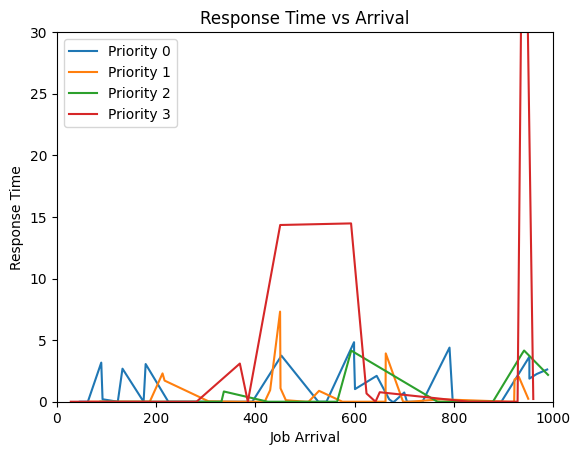

In [63]:
waitingTimesArray = []

for i, job in enumerate(jobsArray):
    waitingTimesArray.append((job.arrival_time,job.pre_waiting_time,job.priority))
    
print(waitingTimesArray)

priority_data = {}
for arrival_time, pre_waiting_time, priority in waitingTimesArray:
    if priority not in priority_data:
        priority_data[priority] = {'arrival_time': [], 'pre_waiting_time': []}
    priority_data[priority]['arrival_time'].append(arrival_time)
    priority_data[priority]['pre_waiting_time'].append(pre_waiting_time)

for priority in range(4):
    if priority in priority_data:
        data = priority_data[priority]
        plt.plot(data['arrival_time'], data['pre_waiting_time'], label=f'Priority {priority}')

plt.xlabel('Job Arrival')
plt.ylabel('Response Time')
plt.ylim(0, 30)
plt.xlim(0, 1000)
plt.title('Response Time vs Arrival')
plt.legend()
plt.show()

## Average Response Time v/s Priority

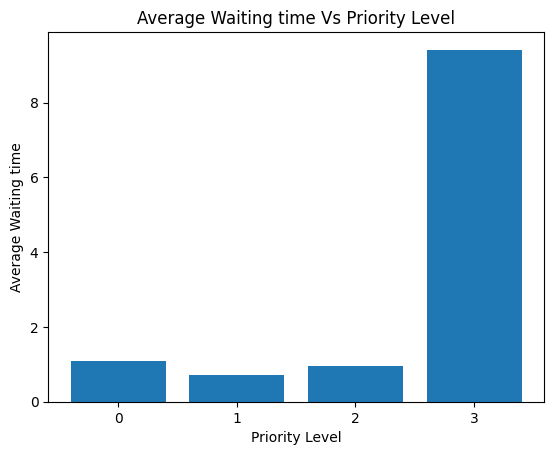

In [64]:
total_jobs_per_priority = [0] * 4
avg_response_time = [0] * 4

for job in jobsArray:
    total_jobs_per_priority[int(job.priority)] += 1
    avg_response_time[int(job.priority)] += job.pre_waiting_time

for i in range(4):
    if total_jobs_per_priority[i] != 0:
        avg_response_time[i] /= total_jobs_per_priority[i]

plt.bar(range(len(avg_response_time)), avg_response_time)
plt.xlabel('Priority Level')
plt.ylabel('Average Waiting time')
plt.title('Average Waiting time Vs Priority Level')
plt.xticks(range(len(avg_response_time)))
plt.show()

## Waiting Times Vs Arrival

[(28.04237706189016, 0.0, 3.0), (46.11759596312337, 0.0, 0.0), (62.41188469401335, 0.0, 0.0), (63.60981575825973, 0.0, 1.0), (87.73571682402662, 2.535740778245369, 2.0), (89.42168407421266, 3.17612228838793, 0.0), (92.03537893710512, 0.20033788692150267, 0.0), (122.76151712145801, 0.0, 0.0), (130.50474666795907, 0.0, 1.0), (132.23711908167544, 2.6824636157110433, 0.0), (137.80383130420506, 0.0, 1.0), (174.7720843689814, 0.0, 0.0), (177.47839312543502, 1.8626573651650347, 1.0), (178.91917223430067, 3.059220891134345, 0.0), (187.21486582083904, 0.0, 1.0), (210.77852389160702, 6.921235406158473, 2.0), (212.979053015568, 2.2994708760390097, 1.0), (217.08460464906892, 1.7153242100143018, 1.0), (224.61194887844755, 0.0, 0.0), (235.22220157651813, 0.0, 0.0), (245.73971447229317, 0.0, 3.0), (256.8204908475234, 0.0, 0.0), (263.39019903065486, 0.0, 0.0), (281.4758595044519, 0.0, 3.0), (298.77750149892086, 0.0, 2.0), (304.5252465958206, 0.0, 0.0), (305.7087968663403, 0.032350983967091906, 1.0), (

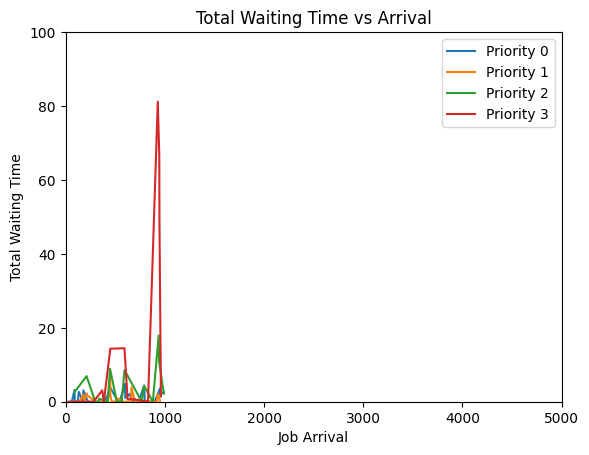

In [65]:
waitingTimesArray = []

for i, job in enumerate(jobsArray):
    waitingTimesArray.append((job.arrival_time,job.pre_waiting_time + job.latency_due_to_preemption ,job.priority))
    
print(waitingTimesArray)

priority_data = {}
for arrival_time, total_waiting_time, priority in waitingTimesArray:
    if priority not in priority_data:
        priority_data[priority] = {'arrival_time': [], 'total_waiting_time': []}
    priority_data[priority]['arrival_time'].append(arrival_time)
    priority_data[priority]['total_waiting_time'].append(total_waiting_time)

for priority in range(4):
    if priority in priority_data:
        data = priority_data[priority]
        plt.plot(data['arrival_time'], data['total_waiting_time'], label=f'Priority {priority}')

plt.xlabel('Job Arrival')
plt.ylabel('Total Waiting Time')
plt.ylim([0,100])
plt.xlim([0,5000])
plt.title('Total Waiting Time vs Arrival')
plt.legend()
plt.show()

## Average Waiting Time v/s Priority

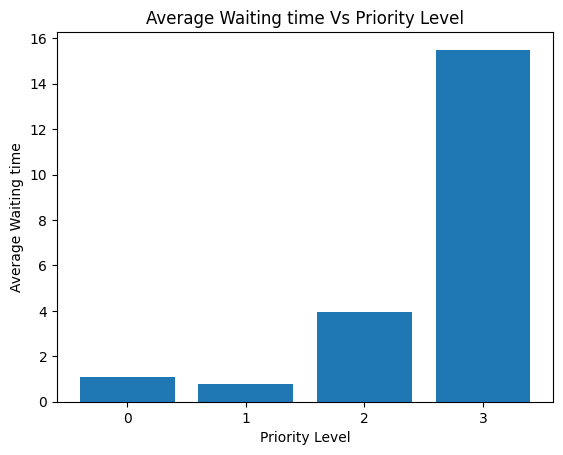

In [66]:
total_jobs_per_priority = [0] * 4
avg_waiting_time = [0] * 4

for job in jobsArray:
    total_jobs_per_priority[int(job.priority)] += 1
    avg_waiting_time[int(job.priority)] += job.waiting_time

for i in range(4):
    if total_jobs_per_priority[i] != 0:
        avg_waiting_time[i] /= total_jobs_per_priority[i]

plt.bar(range(len(avg_waiting_time)), avg_waiting_time)
plt.xlabel('Priority Level')
plt.ylabel('Average Waiting time')
plt.title('Average Waiting time Vs Priority Level')
plt.xticks(range(len(avg_waiting_time)))
plt.show()

## Latency Times Vs Arrival

[(28.04237706189016, 0.0, 3.0), (46.11759596312337, 0, 0.0), (62.41188469401335, 0, 0.0), (63.60981575825973, 0, 1.0), (87.73571682402662, 2.535740778245369, 2.0), (89.42168407421266, 0, 0.0), (92.03537893710512, 0, 0.0), (122.76151712145801, 0, 0.0), (130.50474666795907, 0, 1.0), (132.23711908167544, 0, 0.0), (137.80383130420506, 0, 1.0), (174.7720843689814, 0, 0.0), (177.47839312543502, 1.8626573651650347, 1.0), (178.91917223430067, 0, 0.0), (187.21486582083904, 0.0, 1.0), (210.77852389160702, 6.921235406158473, 2.0), (212.979053015568, 0, 1.0), (217.08460464906892, 0, 1.0), (224.61194887844755, 0, 0.0), (235.22220157651813, 0, 0.0), (245.73971447229317, 0.0, 3.0), (256.8204908475234, 0, 0.0), (263.39019903065486, 0, 0.0), (281.4758595044519, 0.0, 3.0), (298.77750149892086, 0.0, 2.0), (304.5252465958206, 0, 0.0), (305.7087968663403, 0, 1.0), (328.9657492061819, 0, 0.0), (331.67533496071434, 0.0, 2.0), (336.6003180607918, 0.0, 2.0), (368.02160993086886, 0, 1.0), (368.8393426771228, 0.

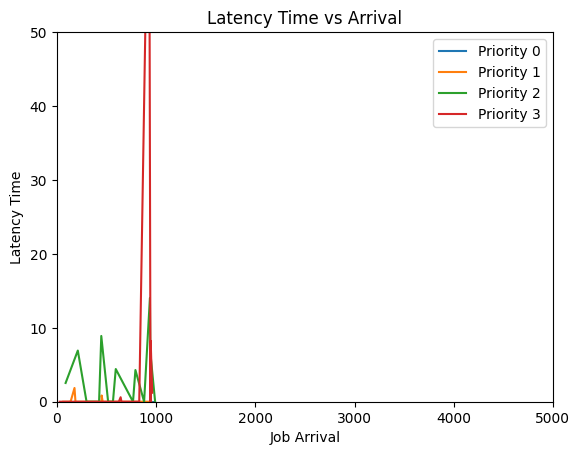

In [67]:
waitingTimesArray = []

for i, job in enumerate(jobsArray):
    waitingTimesArray.append((job.arrival_time,job.latency_due_to_preemption ,job.priority))
    
print(waitingTimesArray)

priority_data = {}
for arrival_time, latency_due_to_preemption, priority in waitingTimesArray:
    if priority not in priority_data:
        priority_data[priority] = {'arrival_time': [], 'latency_due_to_preemption': []}
    priority_data[priority]['arrival_time'].append(arrival_time)
    priority_data[priority]['latency_due_to_preemption'].append(latency_due_to_preemption)

for priority in range(4):
    if priority in priority_data:
        data = priority_data[priority]
        plt.plot(data['arrival_time'], data['latency_due_to_preemption'], label=f'Priority {priority}')



plt.xlabel('Job Arrival')
plt.ylabel('Latency Time')
plt.ylim([0,50])
plt.xlim([0,5000])
plt.title('Latency Time vs Arrival')
plt.legend()
plt.show()

## Average Latency Time v/s Priority

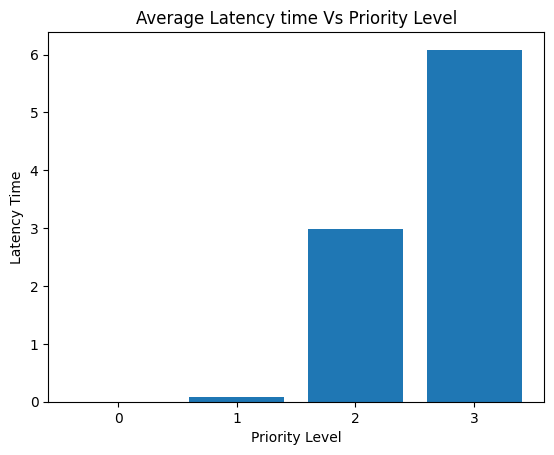

In [68]:
total_jobs_per_priority = [0] * 4
avg_latency = [0] * 4

for job in jobsArray:
    total_jobs_per_priority[int(job.priority)] += 1
    avg_latency[int(job.priority)] += job.latency_due_to_preemption

for i in range(4):
    if total_jobs_per_priority[i] != 0:
        avg_latency[i] /= total_jobs_per_priority[i]

plt.bar(range(len(avg_latency)), avg_latency)
plt.xlabel('Priority Level')
plt.ylabel('Latency Time')
plt.title('Average Latency time Vs Priority Level')
plt.xticks(range(len(avg_latency)))
plt.show()

## Number of Preemptions Vs Priority

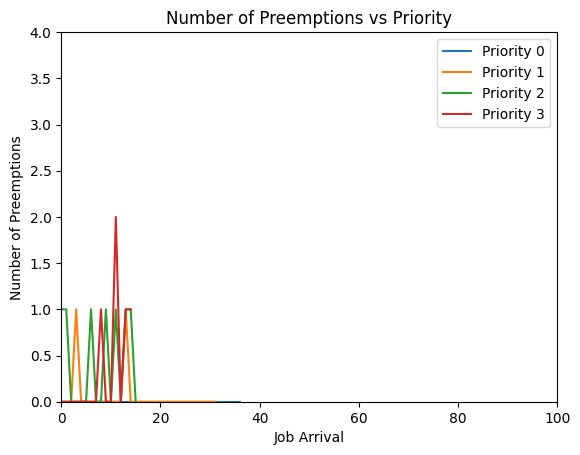

In [69]:
#number of preemptions vs priority

preemptions_data = []

for i, job in enumerate(jobsArray):
    preemptions_data.append((job.num_preemptions,job.priority))

priority_data = {}

for num_preemptions, priority in preemptions_data:
    if priority not in priority_data:
        priority_data[priority] = {'num_preemptions': []}
    priority_data[priority]['num_preemptions'].append(num_preemptions)

for priority in range(4):
    if priority in priority_data:
        data = priority_data[priority]
        plt.plot(data['num_preemptions'], label=f'Priority {priority}')

plt.xlabel('Job Arrival')
plt.ylabel('Number of Preemptions')
plt.ylim(0, 4)
plt.xlim(0, 100)
plt.title('Number of Preemptions vs Priority')
plt.legend()
plt.show()

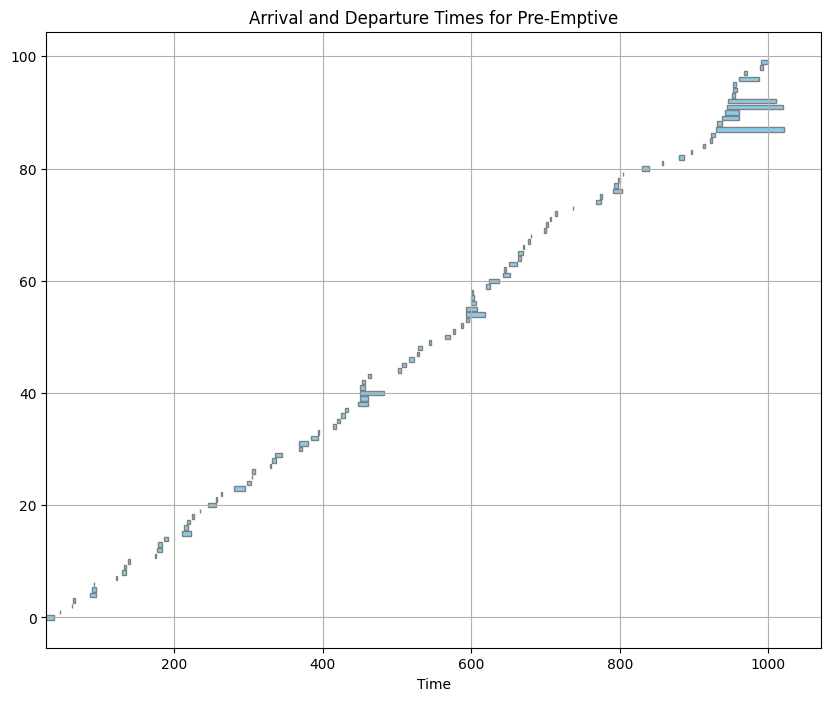

In [70]:
def plot_time_for_each_job_barh(jobsArray):
    arrival_times = []
    duration = []
    index = []
    count = 0
    for i in jobsArray:
        arrival_times.append(i.arrival_time)
        duration.append(i.service_time + i.waiting_time)
        index.append(count)
        count += 1
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(index, duration, left=arrival_times, color='skyblue', edgecolor='grey')
    ax.set_xlabel('Time')
    ax.set_title('Arrival and Departure Times for Pre-Emptive')
    plt.grid(True)
    plt.show()

def number_of_jobs_in_system_at_any_time(jobsArray):
    arrival_times = []
    departure = []
    timestamps=[]
    counts = []
    unit_time = 0.25
    time = 0
    for i in jobsArray:
        arrival_times.append(i.arrival_time)
        departure.append(i.arrival_time + i.service_time + i.waiting_time)
    while(time<max(departure)):
        timestamps.append(time)
        arrivals = 0
        departures = 0
        for atime in arrival_times:
            if atime<time:
                arrivals+=1
        for dtime in departure:
            if dtime<time:
                departures+=1  
        counts.append(arrivals-departures)  
        time += unit_time
    plt.plot(timestamps,counts)
    plt.xlabel("Time")
    plt.ylim(0,5)
    plt.ylabel("Number of jobs in system")
    plt.show()

def which_job_is_being_served(jobsArray):
    timestamps = []
    job_served = []
    colors = []
    time = 0
    unit_time = 0.25
    max_departure = 0
    for job in jobsArray:
        job.first_service = job.arrival_time + job.waiting_time
        job.departure = job.arrival_time+job.waiting_time+job.service_time
        max_departure = max(job.departure,max_departure)     
    while time<max_departure:
        timestamps.append(time)
        flag = 0
        for job in jobsArray:
            if job.first_service<=time and job.departure>time:
                job_served.append(1)
                colors.append(job.color)
                flag = 1
                break
        if flag==0:
            job_served.append(0)
            colors.append("white")
        time += unit_time
    print(colors)
    plt.bar(timestamps,job_served,color=colors)
    plt.xlabel("Time")
    plt.ylabel("Type of job")
    plt.ylim(0,10)
    plt.title("Identity of Jobs with time")
    # plt.savefig("Pre_emptive/arrival_departure.png")
    plt.show()
    
plot_time_for_each_job_barh(jobsArray)
# number_of_jobs_in_system_at_any_time(jobsArray)
# which_job_is_being_served(jobsArray)

## Average Number of Pre emptions Vs Priority

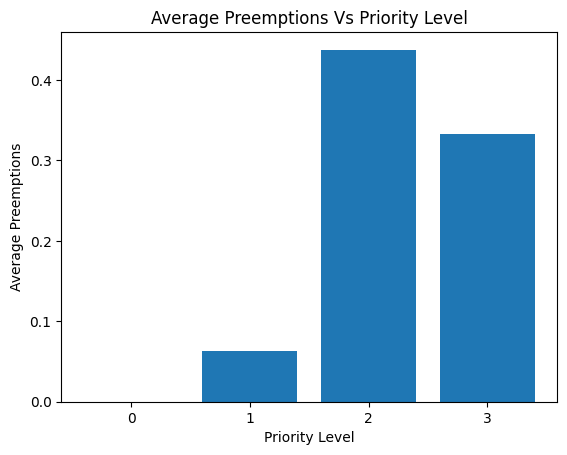

In [71]:
total_jobs_per_priority = [0] * number_of_queues
avg_premptions = [0] * number_of_queues
num_premptions = [0] * number_of_queues

for job in jobsArray:
    total_jobs_per_priority[int(job.priority)] += 1
    num_premptions[int(job.priority)] += job.num_preemptions

for i in range(number_of_queues):
    if total_jobs_per_priority[i] != 0:
        avg_premptions[i] = num_premptions[i] / total_jobs_per_priority[i]

plt.bar(range(len(avg_premptions)), avg_premptions)
plt.xlabel('Priority Level')
plt.ylabel('Average Preemptions')
plt.title('Average Preemptions Vs Priority Level')
plt.xticks(range(len(avg_premptions)))
plt.show()


## Interleaving of jobs

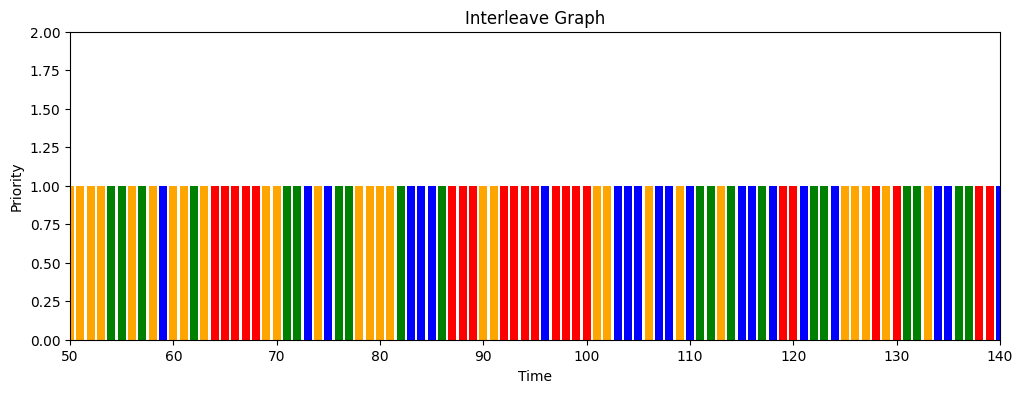

In [77]:
# print("Interleave Graph")
colours = []

for i in range(len(interleave_graph_times)):
    if interleave_graph_times[i][1] == 0:
        colours.append('blue')
    elif interleave_graph_times[i][1] == 1:
        colours.append('orange')
    elif interleave_graph_times[i][1] == 2:
        colours.append('green')
    else:
        colours.append('red')

plt.figure(figsize=(12, 4))
plt.bar(range(len(interleave_graph_times)), [1] * len(interleave_graph_times), color=colours)
plt.ylim(0,2)
plt.xlim(50,140)
plt.xlabel('Time')
plt.ylabel('Priority')
plt.title('Interleave Graph')
plt.show()

